# Исследование поведения пользователей мобильного приложения по продаже продуктов питания

<b> Заказчик: </b>

Стартап, основанный на продаже продуктов питания.

<b> Предоставленные данные: </b>

Лог с данными, содержащий информацию о:
   - EventName — название события;
   - DeviceIDHash — уникальный идентификатор пользователя;
   - EventTimestamp — время события;
   - ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

<b> Задачи исследования: </b>
1. Изучение воронки продаж: 
    - Исследовать путь пользователей до покупки; 
    - Установить количество пользователей совершивших покупку и недошедших до этого события; 
    - Выявить этапы на которых "застревают" пользователи.
2. Исследование результатов A/A/B-эксперимента: 
    - Изучить результаты эксперимента и выявить, при наличии, закономерности, влияющие на изменение активности пользователей экспериментальной группы с отличающимся шрифтом.


## Загрузка данных и изучение общей информации

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/Users/vintera/Git/projects/my_projects/dataset/project_09/logs_exp.csv', sep='\t')

In [3]:
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
188066,MainScreenAppear,4022914497222644222,1565084333,247
178527,MainScreenAppear,4324680624591436809,1565063630,248
186271,MainScreenAppear,3896142600614297711,1565081128,247
197492,CartScreenAppear,3940194724501792579,1565100602,248
42671,MainScreenAppear,5696093535989664031,1564721324,248


In [4]:
df.EventName.value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: EventName, dtype: int64

In [5]:
df.ExpId.value_counts()

248    85747
246    80304
247    78075
Name: ExpId, dtype: int64

### Вывод
С данными познакомились, можно приступать к их обработке.

## Предобработка и исследование данных

In [6]:
# Для удобства переименуем столбцы
df = df.rename(columns={'EventName' : 'event',
                        'DeviceIDHash' : 'id',
                        'EventTimestamp' : 'dt',
                        'ExpId' : 'group'})

In [7]:
# Преобразуем столбец с датой и временем к соответствующему формату
df.dt = pd.to_datetime(df.dt, unit='s')

In [8]:
# Создадим столбец, содержащий только дату события
df['date'] = df.dt.astype('datetime64[D]')

In [9]:
# Проверим наличие дубликатов и избавимся от них
print('Строк дублируется: {:.0f},'.format(df.duplicated().sum()),
      'что составляет: {:.2%} от общего количества строк.'.format((df.duplicated().sum() / len(df))))

Строк дублируется: 413, что составляет: 0.17% от общего количества строк.


In [10]:
df = df.drop_duplicates().reset_index(drop=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   event   243713 non-null  object        
 1   id      243713 non-null  int64         
 2   dt      243713 non-null  datetime64[ns]
 3   group   243713 non-null  int64         
 4   date    243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


#### Вывод
Столбцы переименованны, информация о датах приведена к нужному формату, пропуски отсутствуют а дубликаты удалены. Можно переходить к следующему этапу.

## Исследовательский анализ данных (EDA)

In [12]:
print('Всего событий в логе:', df.event.count())

Всего событий в логе: 243713


In [13]:
print('Всего пользователей в логе:', df.id.nunique())

Всего пользователей в логе: 7551


In [14]:
print('В среднем на пользователя приходится', int((df.event.count() / df.id.nunique()).round()), 'события')

В среднем на пользователя приходится 32 события


In [15]:
print('Первая дата в логе:', df.dt.min())
print('Последняя дата в логе:', df.dt.max())

Первая дата в логе: 2019-07-25 04:43:36
Последняя дата в логе: 2019-08-07 21:15:17


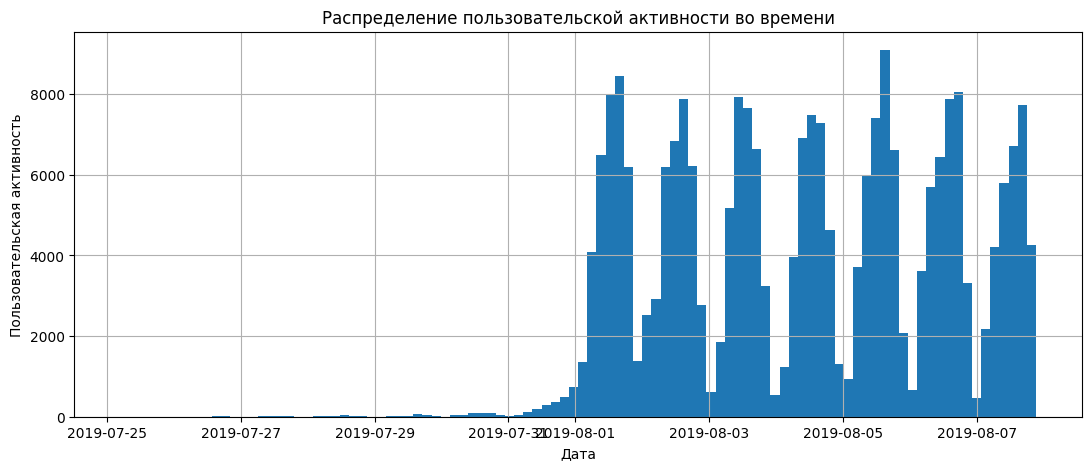

In [16]:
# Построим гистограмму распределения пользовательской активности во времени
df['dt'].hist(bins=100, figsize=(13,5))
plt.title('Распределение пользовательской активности во времени')
plt.xlabel('Дата')
plt.ylabel('Пользовательская активность');

In [17]:
print('95% данных сосредоточено после', df.dt.quantile(0.05))

95% данных сосредоточено после 2019-08-01 09:28:05


### Комментарий
Как можно заметить на графике, практически все данные о пользовательской активности сосредоточены после 1 августа.

In [18]:
# Создадим обновленный датафрейм, содержащий информацию начиная с 1 августа
new_df = df.query('dt > "2019-08-01 00:00:00"')

In [19]:
print('Отбросив старые данные, мы потеряли', 
      df['event'].count() - new_df['event'].count(),
      'событий, что составляет {:.2%} от общего количества данных'.format(
      ((df['event'].count() - new_df['event'].count()) / df['event'].count())))

Отбросив старые данные, мы потеряли 2826 событий, что составляет 1.16% от общего количества данных


In [20]:
print('Отбросив старые данные, мы потеряли', 
      df['id'].nunique() - new_df['id'].nunique(),
      'уникальных пользователей, что составляет {:.2%} от общего количества данных'.format(
      (df['id'].nunique() - new_df['id'].nunique()) / df['id'].nunique()))

Отбросив старые данные, мы потеряли 17 уникальных пользователей, что составляет 0.23% от общего количества данных


In [21]:
new_df.groupby('group').agg({'id':'nunique'})

,id
group,
246,2484
247,2513
248,2537


### Комментарий
Во всех группах осталось приблизительно равное количество уникальных пользователей.

## Изучение воронки событий

In [22]:
all_events = new_df.groupby('event').agg({'id' : 'count'}).sort_values(
    by = 'id', ascending = False).reset_index()
all_events

,event,id
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


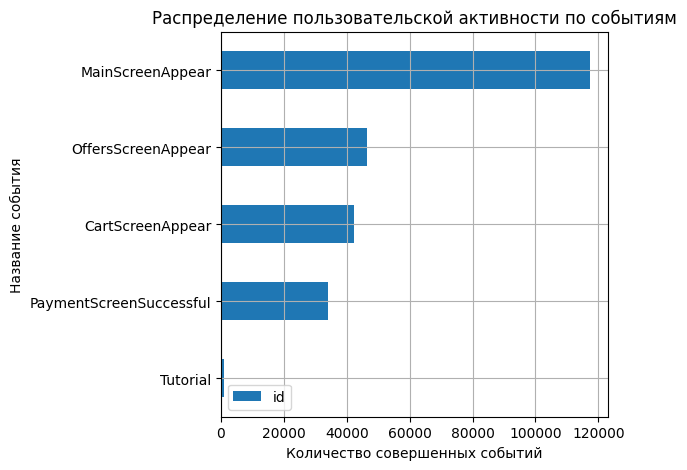

In [23]:
all_events.sort_values(by='id').plot(kind='barh', x='event', y='id', grid=True, figsize=(5,5))
plt.title('Распределение пользовательской активности по событиям')
plt.xlabel('Количество совершенных событий')
plt.ylabel('Название события');

### Комментарий
В логе присутствует 5 видов событий. Начиная от самого популярного, это:
 - MainScreenAppear	(Главная страница);
 - OffersScreenAppear (Страница предложений);
 - CartScreenAppear (Страница корзины);
 - PaymentScreenSuccessful (Страница успешной оплаты);
 - Tutorial (Руководство пользователя).

Порядок событий: 1. Main Screen Appear → 2. Offers Screen Appear → 3. Cart Screen Appear → 4. Payment Screen Successful 

Событие "Tutorial" - как правило ситуационное, к нему пользователи могут прийти на любом из этапов, а могут и не воспользоваться совсем.

### Воронка всех пользователей

In [24]:
# Сгруппируем количество всех событий по датам
users_funnel = new_df.pivot_table(
    index='date', 
    columns='event', 
    values='id',
    aggfunc='count')
users_funnel

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
date,,,,,
2019-08-01 00:07:28,NaN,NaN,NaN,NaN,1.0
2019-08-01 00:08:00,NaN,1.0,NaN,NaN,NaN
2019-08-01 00:08:55,NaN,1.0,NaN,NaN,NaN
2019-08-01 00:08:58,NaN,NaN,1.0,NaN,NaN
2019-08-01 00:08:59,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...
2019-08-07 21:12:25,NaN,1.0,NaN,NaN,NaN
2019-08-07 21:13:59,NaN,1.0,NaN,NaN,NaN
2019-08-07 21:14:43,NaN,1.0,NaN,NaN,NaN


In [25]:
# Построим график воронки событий, где значения, разбитые по датам, суммируем 
fig = go.Figure(go.Funnel(
    y = ["Главная страница",
         "Страница предложений", 
         "Страница корзины", 
         "Страница успешной оплаты"],
    x = [users_funnel.MainScreenAppear.sum(), 
         users_funnel.OffersScreenAppear.sum(), 
         users_funnel.CartScreenAppear.sum(), 
         users_funnel.PaymentScreenSuccessful.sum()]
    ))
fig.show()

#### Вывод
61.5% теряется на этапе перехода от главной страницы к странице предложений. Больше половины пользователей теряется именно на этом этапе. От первого события до оплаты доходит лишь 28.9% пользователей.

### Воронка уникальных пользователей

In [26]:
print('Пользователей, совершивших хотя бы одно событие:',new_df.id.nunique())

Пользователей, совершивших хотя бы одно событие: 7534


In [27]:
# Создадим сводную таблицу, где значениями будут первые даты событий, совершенных пользователями
users = new_df.pivot_table(
    index='id', 
    columns='event', 
    values='dt',
    aggfunc='min').reset_index()

In [28]:
# Построим воронку и посчитаем пользователей, которые хоть раз совершали то или иное событие
fig = go.Figure(go.Funnel(
    y = ["Главная страница",
         "Страница предложений", 
         "Страница корзины", 
         "Страница успешной оплаты"],
    x = [users.MainScreenAppear.count(), 
         users.OffersScreenAppear.count(), 
         users.CartScreenAppear.count(), 
         users.PaymentScreenSuccessful.count()]
    ))
fig.show()

#### Комментарий
Исходя из расчета воронки уникальных пользователей на этапе перехода от главной страницы к странице предложения так же теряется бОльшая часть пользователей - 38.1%. На последующих этапах, убыль пользователей не так значительна.

Учитывая, что всего уникальных пользователей 7534, а как мы видим из графика, на главную страницу зашло только 7419, можно предположить, что как минимум 115 пользователей начинали пользоваться приложением не с главной страницы. Возможно это особенность приложения, а возможно ошибка. Необходимо будет уточнить у заказчика.

In [29]:
users.query('OffersScreenAppear < MainScreenAppear')['id'].count()
users.query('CartScreenAppear < MainScreenAppear')['id'].count()
users.query('PaymentScreenSuccessful < MainScreenAppear')['id'].count()

280

203

172

#### Вывод
Как минимум 655 пользователей начинают пользоваться приложением не с главного экрана. Данный факт может негативно отразиться на результатах исследования, поэтому сообщим об этом дата-инжинерам, руководству или заказчику. Пока ответ не получен и неизвестно какие действия предпринимать, продолжим проводить исследование с имеющимися данными.

### Воронка с учетом последовательности событий

In [30]:
# Пошагово рассчитаем количество пользователей с учетом последовательности событий
step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

n_main_screen = users[step_1].shape[0]
n_offer = users[step_2].shape[0]
n_cart = users[step_3].shape[0]
n_payment_successful = users[step_4].shape[0]

In [31]:
# Аналогично построим воронку
fig = go.Figure(go.Funnel(
    y = ["Главная страница",
         "Страница предложений", 
         "Страница корзины", 
         "Страница успешной оплаты"],
    x = [n_main_screen, 
         n_offer, 
         n_cart, 
         n_payment_successful]
    ))
fig.show()

#### Комментарий
С учетом последовательности событий, картина кажется более разочаровывающей. 74.3% теряется на этапе перехода от корзины к успешной оплате ее содержимого.

От главной страницы до успешной оплаты доходит лишь 6.1% пользователей.

#### Вывод

Рассмотрев воронки событий по трем вариациям пользователей, в первую очередь следует обратить внимание на воронку, построенную с учетом последовательности событий, где на каждом этапе воронки отсеивается почти половина пользователей, а до успешной оплаты доходит всего 454 пользователя из 7419, что составляет 6.1%. При переходе от корзины к оплате товара теряется самое большое количество пользователей - 74.3%. Возможно в приложении, на указаном этапе у пользователей возникают трудности, связанные с техническими неполадками.

## Изучение результатов эксперимента

In [32]:
# Разделим пользователей по группам и проверим на данные на совпадение id
group_246 = new_df.query('group == 246')
id_246 = pd.Series(group_246['id'])

group_247 = new_df.query('group == 247')
id_247 = pd.Series(group_247['id'])

group_248 = new_df.query('group == 248')
id_248 = pd.Series(group_248['id'])

group_246.query('id in @id_247')['id'].count()
group_246.query('id in @id_248')['id'].count()
group_247.query('id in @id_248')['id'].count()
group_247.query('id in @id_246')['id'].count()
group_248.query('id in @id_246')['id'].count()
group_248.query('id in @id_247')['id'].count()

0

0

0

0

0

0

### Комментарий
Повторяющиеся id не выявлены.

In [33]:
user_groups = new_df.groupby('group').agg({'id' : 'nunique'})
user_groups

,id
group,
246,2484
247,2513
248,2537


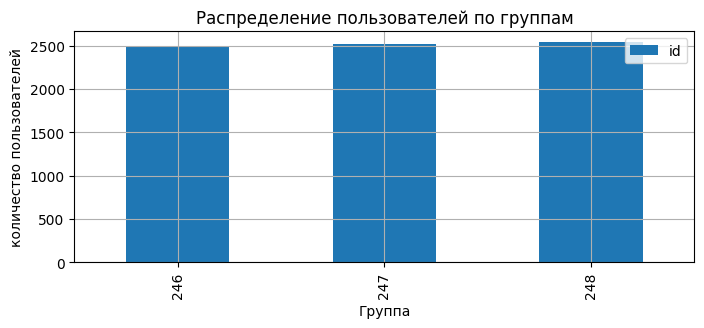

In [34]:
user_groups.plot(kind='bar', grid=True, figsize=(8,3))
plt.title('Распределение пользователей по группам')
plt.xlabel('Группа')
plt.ylabel('количество пользователей');

### Комментарий
Количество пользователей в группах приблизительно одинаковое.

### Проверка гипотез
Сформулируем гипотезы для сравниваемых долей:
    
    H₀ - Нет оснований считать доли разными.

    H₁ - Между долями есть значимая разница.

In [35]:
# Создадим функцию, где в параметрах укажем датасет, название события, сравниваемые группы и значение альфа
def Ztest(data, event, gr1, gr2, alpha):
    
    # Посчитаем количество совершенных событий и уникальных пользователей в группах
    gr1_event = data.query('group == @gr1 and @event in event').id.nunique()
    gr2_event = data.query('group == @gr2 and @event in event').id.nunique()
    gr1_users = data.query('group == @gr1').id.nunique()
    gr2_users = data.query('group == @gr2').id.nunique()
    
    # Посчитаем доли в группах и разницу между ними
    p1 = gr1_event / gr1_users
    p2 = gr2_event / gr2_users
    difference = p1 - p2
    
    p_combined = (gr1_event + gr2_event) / (gr1_users + gr2_users)
    
    # Посчитаем статистику в стандартных отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/gr1_users + 1/gr2_users))
    
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Событие: {}'.format(event))
    print('Сравниваемые группы: {}, {}'.format(gr1, gr2))
    print('------------------------------')
    print('p-значение: ', round(p_value, 5))
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [36]:
Ztest(new_df, 'MainScreenAppear', 246, 247, 0.05)

Событие: MainScreenAppear
Сравниваемые группы: 246, 247
------------------------------
p-значение:  0.75706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Вывод
Разница в статистических критериях между выборками 246 и 247 в событии "Главная страница" не выявлена.

In [37]:
# Разделим события на группы и посчитаем для каждого доли
popular_event = new_df.pivot_table(
        index='group', 
        columns='event', 
        values='id',
        aggfunc='nunique').reset_index()

popular_event['total'] = popular_event[['Tutorial', 
                               'MainScreenAppear', 
                               'OffersScreenAppear', 
                               'CartScreenAppear',
                               'PaymentScreenSuccessful']].sum(axis=1)
popular_event['tutorial_ratio'] = (popular_event['Tutorial'] / popular_event['total']).round(3)
popular_event['main_ratio'] = (popular_event['MainScreenAppear'] / popular_event['total']).round(3)
popular_event['offer_ratio'] = (popular_event['OffersScreenAppear'] / popular_event['total']).round(3)
popular_event['cart_ratio'] = (popular_event['CartScreenAppear'] / popular_event['total']).round(3)
popular_event['payment_ratio'] = (popular_event['PaymentScreenSuccessful'] / popular_event['total']).round(3)

popular_event = popular_event[['group',
                               'total',
                               'Tutorial',
                               'tutorial_ratio',
                               'MainScreenAppear',
                               'main_ratio',
                               'OffersScreenAppear',
                               'offer_ratio',
                               'CartScreenAppear',
                               'cart_ratio',
                               'PaymentScreenSuccessful',
                               'payment_ratio']]
popular_event

event,group,total,Tutorial,tutorial_ratio,MainScreenAppear,main_ratio,OffersScreenAppear,offer_ratio,CartScreenAppear,cart_ratio,PaymentScreenSuccessful,payment_ratio
0,246,6736,278,0.041,2450,0.364,1542,0.229,1266,0.188,1200,0.178
1,247,6675,283,0.042,2476,0.371,1520,0.228,1238,0.185,1158,0.173
2,248,6714,279,0.042,2493,0.371,1531,0.228,1230,0.183,1181,0.176


#### Вывод
Самым популярным событием для всех групп будет переход на главный экран. Доли между группами приблизительно равны.

#### Сравнение контрольных групп 246 и 247

In [38]:
print('1.')
Ztest(new_df, 'MainScreenAppear', 246, 247, 0.05)
print('2.')
Ztest(new_df, 'OffersScreenAppear', 246, 247, 0.05)
print('3.')
Ztest(new_df, 'CartScreenAppear', 246, 247, 0.05)
print('4.')
Ztest(new_df, 'PaymentScreenSuccessful', 246, 247, 0.05)
print('5.')
Ztest(new_df, 'Tutorial', 246, 247, 0.05)

1.
Событие: MainScreenAppear
Сравниваемые группы: 246, 247
------------------------------
p-значение:  0.75706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
2.
Событие: OffersScreenAppear
Сравниваемые группы: 246, 247
------------------------------
p-значение:  0.2481
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
3.
Событие: CartScreenAppear
Сравниваемые группы: 246, 247
------------------------------
p-значение:  0.22883
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
4.
Событие: PaymentScreenSuccessful
Сравниваемые группы: 246, 247
------------------------------
p-значение:  0.11457
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
5.
Событие: Tutorial
Сравниваемые группы: 246, 247
------------------------------
p-значение:  0.9377
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Вывод
По результатам проведенных тестов можно полагать, что разбиение на группы работает корректно.

#### Сравнение контрольных групп 246, 247 с экспериментальной 248

In [39]:
print('1.')
Ztest(new_df, 'MainScreenAppear', 246, 248, 0.05)
print('2.')
Ztest(new_df, 'OffersScreenAppear', 246, 248, 0.05)
print('3.')
Ztest(new_df, 'CartScreenAppear', 246, 248, 0.05)
print('4.')
Ztest(new_df, 'PaymentScreenSuccessful', 246, 248, 0.05)
print('5.')
Ztest(new_df, 'Tutorial', 246, 248, 0.05)

1.
Событие: MainScreenAppear
Сравниваемые группы: 246, 248
------------------------------
p-значение:  0.29497
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
2.
Событие: OffersScreenAppear
Сравниваемые группы: 246, 248
------------------------------
p-значение:  0.20836
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
3.
Событие: CartScreenAppear
Сравниваемые группы: 246, 248
------------------------------
p-значение:  0.07843
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
4.
Событие: PaymentScreenSuccessful
Сравниваемые группы: 246, 248
------------------------------
p-значение:  0.21226
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
5.
Событие: Tutorial
Сравниваемые группы: 246, 248
------------------------------
p-значение:  0.82643
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [40]:
print('1.')
Ztest(new_df, 'MainScreenAppear', 247, 248, 0.05)
print('2.')
Ztest(new_df, 'OffersScreenAppear', 247, 248, 0.05)
print('3.')
Ztest(new_df, 'CartScreenAppear', 247, 248, 0.05)
print('4.')
Ztest(new_df, 'PaymentScreenSuccessful', 247, 248, 0.05)
print('5.')
Ztest(new_df, 'Tutorial', 247, 248, 0.05)

1.
Событие: MainScreenAppear
Сравниваемые группы: 247, 248
------------------------------
p-значение:  0.45871
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
2.
Событие: OffersScreenAppear
Сравниваемые группы: 247, 248
------------------------------
p-значение:  0.91978
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
3.
Событие: CartScreenAppear
Сравниваемые группы: 247, 248
------------------------------
p-значение:  0.57862
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
4.
Событие: PaymentScreenSuccessful
Сравниваемые группы: 247, 248
------------------------------
p-значение:  0.73734
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
5.
Событие: Tutorial
Сравниваемые группы: 247, 248
------------------------------
p-значение:  0.76532
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Вывод
Статистически значимые различия между контрольными группами и группой с измененным шрифтом отсутствуют.

#### Сравнение объединенной контрольной группы с экспериментальной

In [41]:
pooled_control_group = new_df.copy()

In [42]:
pooled_control_group.group = pooled_control_group.group.replace({246: 493, 247: 493})
# Назовем объединенную контрольную группу - 493

In [43]:
print('1.')
Ztest(pooled_control_group, 'MainScreenAppear', 493, 248, 0.05)
print('2.')
Ztest(pooled_control_group, 'OffersScreenAppear', 493, 248, 0.05)
print('3.')
Ztest(pooled_control_group, 'CartScreenAppear', 493, 248, 0.05)
print('4.')
Ztest(pooled_control_group, 'PaymentScreenSuccessful', 493, 248, 0.05)
print('5.')
Ztest(pooled_control_group, 'Tutorial', 493, 248, 0.05)

1.
Событие: MainScreenAppear
Сравниваемые группы: 493, 248
------------------------------
p-значение:  0.29425
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
2.
Событие: OffersScreenAppear
Сравниваемые группы: 493, 248
------------------------------
p-значение:  0.43426
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
3.
Событие: CartScreenAppear
Сравниваемые группы: 493, 248
------------------------------
p-значение:  0.18176
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
4.
Событие: PaymentScreenSuccessful
Сравниваемые группы: 493, 248
------------------------------
p-значение:  0.60043
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
5.
Событие: Tutorial
Сравниваемые группы: 493, 248
------------------------------
p-значение:  0.76486
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Вывод
При сравнении объединенной контрольной группы и экспериментальной группы с измененным шрифтом, различия между ними также отсутствуют. 

В общей сложности было проведено 20 тестов, по результатам которых опровергнуть нулевую гипотезу не получилось, основания считать доли разными отсутствуют. Для проведения тестов использовался уровень значимости равный 0.05, то есть каждый двадцатый раз можно было получить ложный результат. Изменять уровень значимости и проводить новые тесты нецелесообразно, так как в проведенных тестах р-значения почти всегда были достаточно высоки, что говорит о точности результатов эксперимента.

## Общий вывод и рекомендации бизнесу

Подводя итог исследования и отвечая на вопросы поставленных задач, можно сделать следующие выводы:

<b>1. Воронка продаж:</b>
- При использовании приложения, пользователи как правило соблюдают следующий порядок событий: Main Screen Appear → Offers Screen Appear → Cart Screen Appear → Payment Screen Successful. Событие Tutorial пользователи проходят на свое усмотрение;
- Из 7419 уникальных пользователей, посетивших главную страницу, до успешной покупки дошло лишь 454 пользователя, соблюдая логику выполнения событий. То есть 6965 (93.9%) пользователей, посетивших главную страницу, отсеялись так и не совершив покупу, что говорит о крайне слабых показателях продаж;
- Большая часть пользователей отсекается после просмотра главной страницы, что можно объяснить отсутствием интереса к представленным товарам. Однако следует обратить пристальное внимание на 74.3 % пользователей, которые выбрали заинтересовавший их товар, зашли в корзину для оформления покупки, но так и не совершили оплату. Можно предположить, что какая-то часть передумывает совершать покупку, увидев итоговую сумму или по иным причинам, но высокий процент таких пользователей подсказывает, что это является не единственной причиной отказа от совершения оплаты и возможно объясняется трудностями или техническими ошибками в приложении при осуществлении платежа.

<b>2. Исследование результатов A/A/B-эксперимента:</b>
- Набор в группы был совершен корректно - количество пользователей распределено практически поровну, среди групп они не повторяются, а проведенным тестированием установлено, что статистически значимые различия в двух контрольных группах отсутствуют.
- При проведении сравнительных тестов контрольных групп, а также их объединенной версии с экспериментальной группой, статистически значимые различия не обнаружены. Измененный шрифт в экспериментальной группе никак не влияет на пользовательскую активность.